In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrsanishshrestha","key":"785c2946617dd4aaf4143d214fb7b90c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0


In [6]:
import zipfile

with zipfile.ZipFile("cards-image-datasetclassification.zip", 'r') as zip_ref:
    zip_ref.extractall("cards_dataset")

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import sys
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [8]:
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)


  def __len__(self):
    return len(self.data)


  def __getitem__(self,idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes




In [9]:
dataset = PlayingCardDataset(
    data_dir = './cards_dataset/train'
)

In [10]:
!find . -type d -name "*cards*"

./cards_dataset


In [11]:
len(dataset)

7624

34


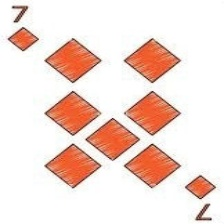

In [12]:
image, label = dataset[5000]
print(label)
image

In [13]:
data_dir = './cards_dataset/train'
target_to_class = {v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [14]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
data_dir = './cards_dataset/train'
dataset = PlayingCardDataset(data_dir, transform)

In [15]:
image, label = dataset[2600]
label
image.shape

torch.Size([3, 128, 128])

In [16]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

In [17]:
for images, labels in dataloader:
  break

In [18]:
image

tensor([[[0.9804, 0.9843, 0.9843,  ..., 0.9804, 0.9843, 0.9765],
         [0.9804, 0.9529, 0.7765,  ..., 0.9725, 0.9765, 0.9843],
         [0.8902, 0.6196, 0.6000,  ..., 0.7647, 0.9725, 0.9725],
         ...,
         [0.8902, 0.9804, 0.9922,  ..., 0.9373, 0.5765, 0.6667],
         [0.4784, 0.8353, 0.9804,  ..., 0.6588, 0.5882, 0.8980],
         [0.6627, 0.5020, 0.8706,  ..., 0.5137, 0.8588, 0.9804]],

        [[0.9882, 0.9882, 0.9843,  ..., 0.9804, 0.9843, 0.9765],
         [0.9804, 0.9529, 0.7765,  ..., 0.9725, 0.9765, 0.9843],
         [0.8902, 0.6196, 0.6000,  ..., 0.7647, 0.9725, 0.9725],
         ...,
         [0.8902, 0.9804, 0.9922,  ..., 0.9373, 0.5765, 0.6667],
         [0.4784, 0.8353, 0.9804,  ..., 0.6588, 0.5882, 0.8980],
         [0.6627, 0.5020, 0.8706,  ..., 0.5137, 0.8588, 0.9804]],

        [[0.9843, 0.9882, 0.9843,  ..., 0.9804, 0.9843, 0.9765],
         [0.9804, 0.9529, 0.7765,  ..., 0.9725, 0.9765, 0.9843],
         [0.8902, 0.6196, 0.6000,  ..., 0.7647, 0.9725, 0.

In [19]:
class SimpleCardClassifier(nn.Module):
  def __init__(self, num_classes = 53):
    super(SimpleCardClassifier, self).__init__()
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    enet_out_size=1280

    self.classifier = nn.Linear(enet_out_size,num_classes)

  def forward(self,x):
    x=self.features(x)
    output = self.classifier(x)
    return output

In [20]:
model = SimpleCardClassifier(num_classes = 53)
model(images)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

tensor([[ 0.1646,  0.0795,  0.0455,  ..., -0.0970,  0.0473,  0.1776],
        [-0.0579, -0.1928,  0.0882,  ..., -0.0179, -0.2124, -0.0841],
        [ 0.1738,  0.4722, -0.0934,  ...,  0.1748,  0.7095, -0.4611],
        ...,
        [ 0.3527, -0.4645, -0.0481,  ...,  0.3287, -0.0659, -0.4794],
        [-0.3168, -0.4747,  0.1410,  ..., -0.2875,  0.0599, -0.5607],
        [-0.1016,  0.2888, -0.1244,  ..., -0.0746, -0.0339,  0.1197]],
       grad_fn=<AddmmBackward0>)

In [21]:
example_out= model(images)
example_out.shape

torch.Size([32, 53])

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
criterion(example_out,labels)

tensor(4.0193, grad_fn=<NllLossBackward0>)

In [31]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_folder = './cards_dataset/train'
valid_folder = './cards_dataset/valid'
test_folder = 'cards_dataset/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size =32, shuffle=True)

In [25]:
!nvidia-smi

Sun Apr 20 16:25:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [32]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.565201284002282, Validation loss: 0.34733338895833715


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5309797672384808, Validation loss: 0.17337873814240942


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.34232754494060624, Validation loss: 0.21010003629720436


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.24961088303816656, Validation loss: 0.20120977005868587


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19299793103074603, Validation loss: 0.23697128745744814


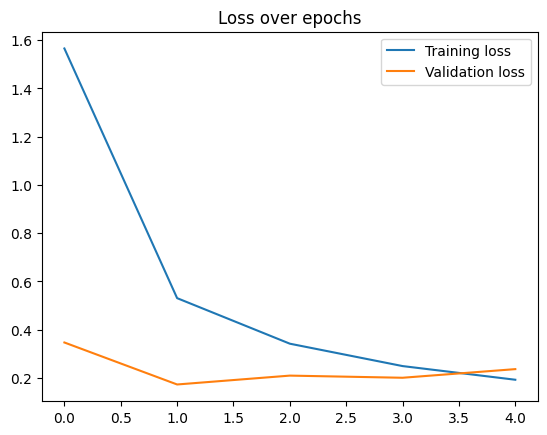

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [34]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def preprocess_image(image_path, transform):
  image = Image.open(image_path).convert('RGB')
  return image, transform(image).unsqueeze(0)
def predict(mode, image_tensor, device):
  model.eval()
  with torch.no_grad():
    image_tensor = image_tensor.to(device)
    outputs = model(image_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
  return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
  fig, axarr = plt.subplots(1,2,figsize=(14,7))

  axarr[0].imshow(original_image)
  axarr[0].axis('off')

  axarr[1].barh(class_names, probabilities)
  axarr[1].set_xlabel('Probability')
  axarr[1].set_title('Class Predictions')
  axarr[1].set_xlim(0,0.2)

  plt.tight_layout()
  plt.show()


test_image = './cards_dataset/test/five of hearts/3.jpg'

transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])


original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)
class_names = dataset.classes

visualize_predictions(original_image, probabilities, class_names)

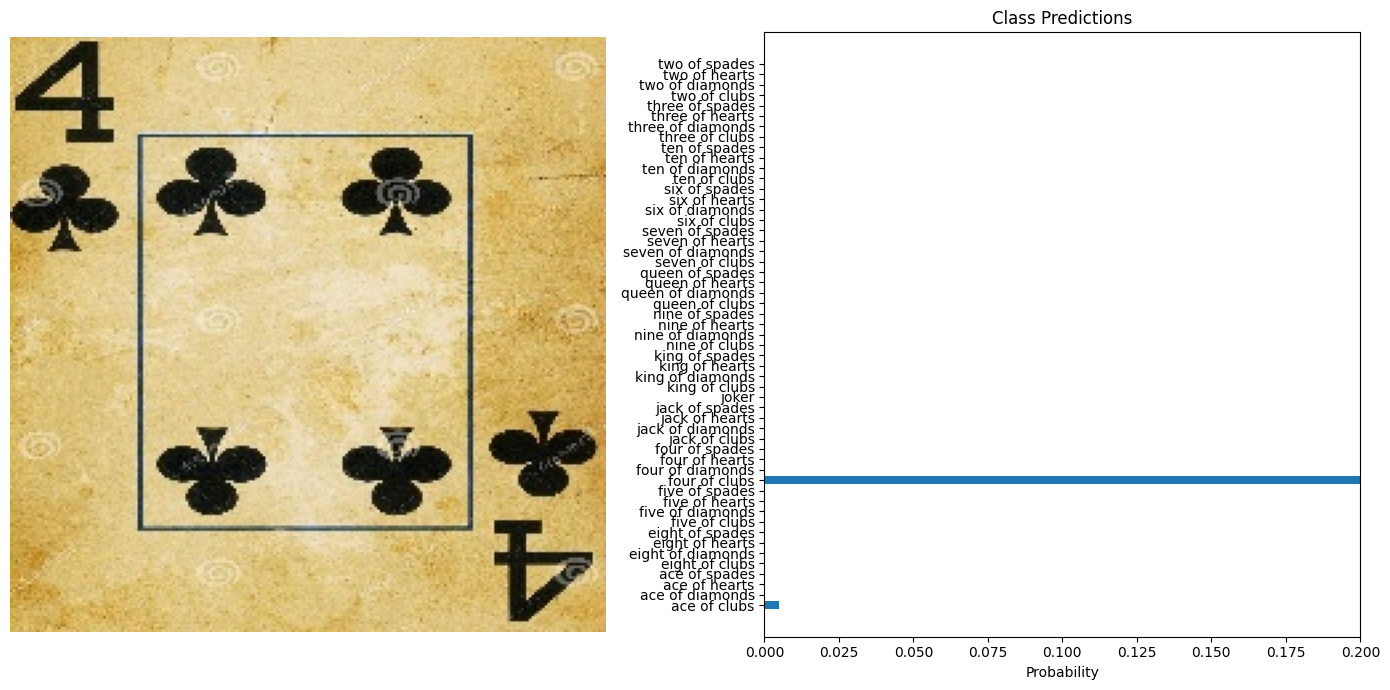

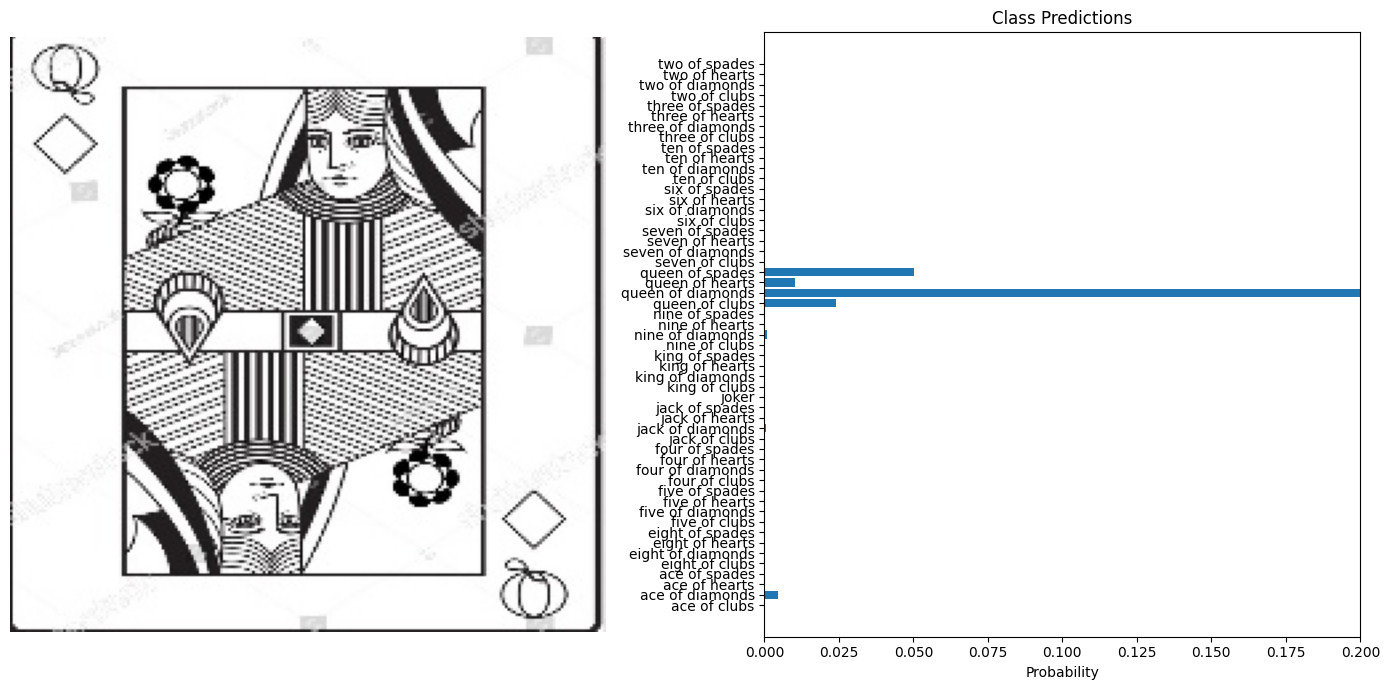

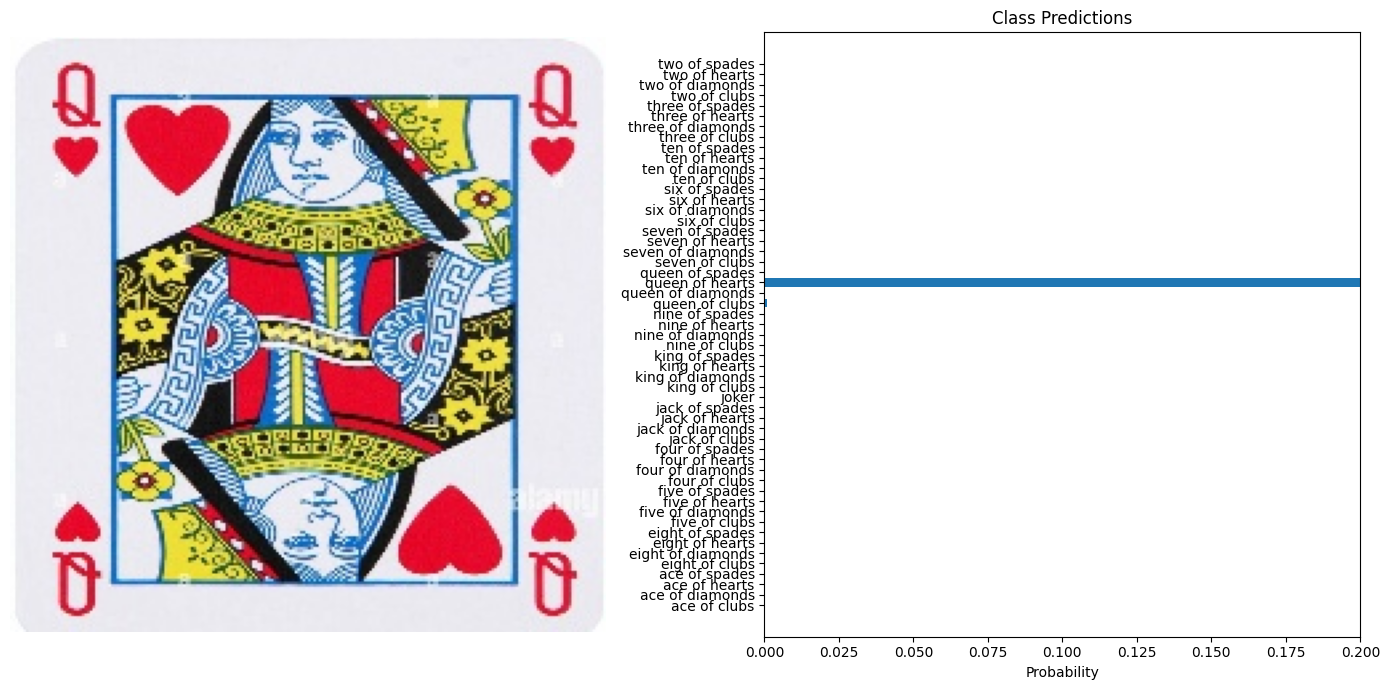

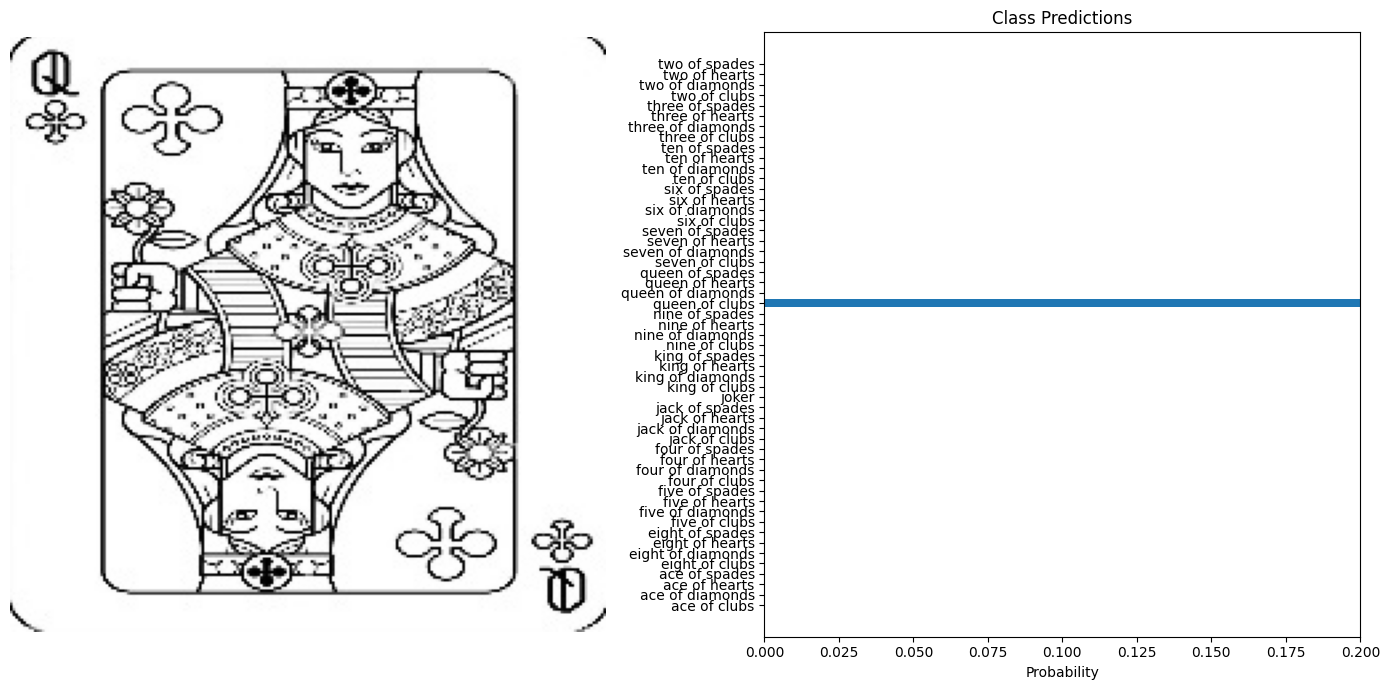

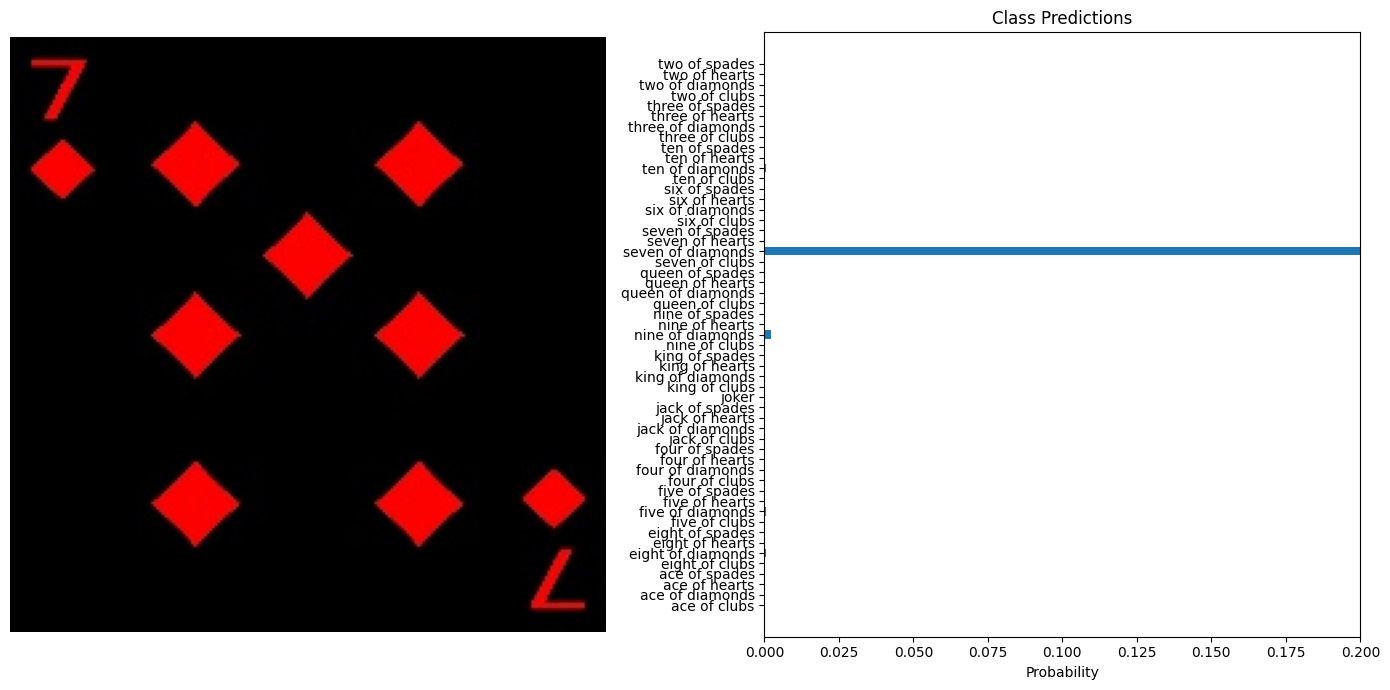

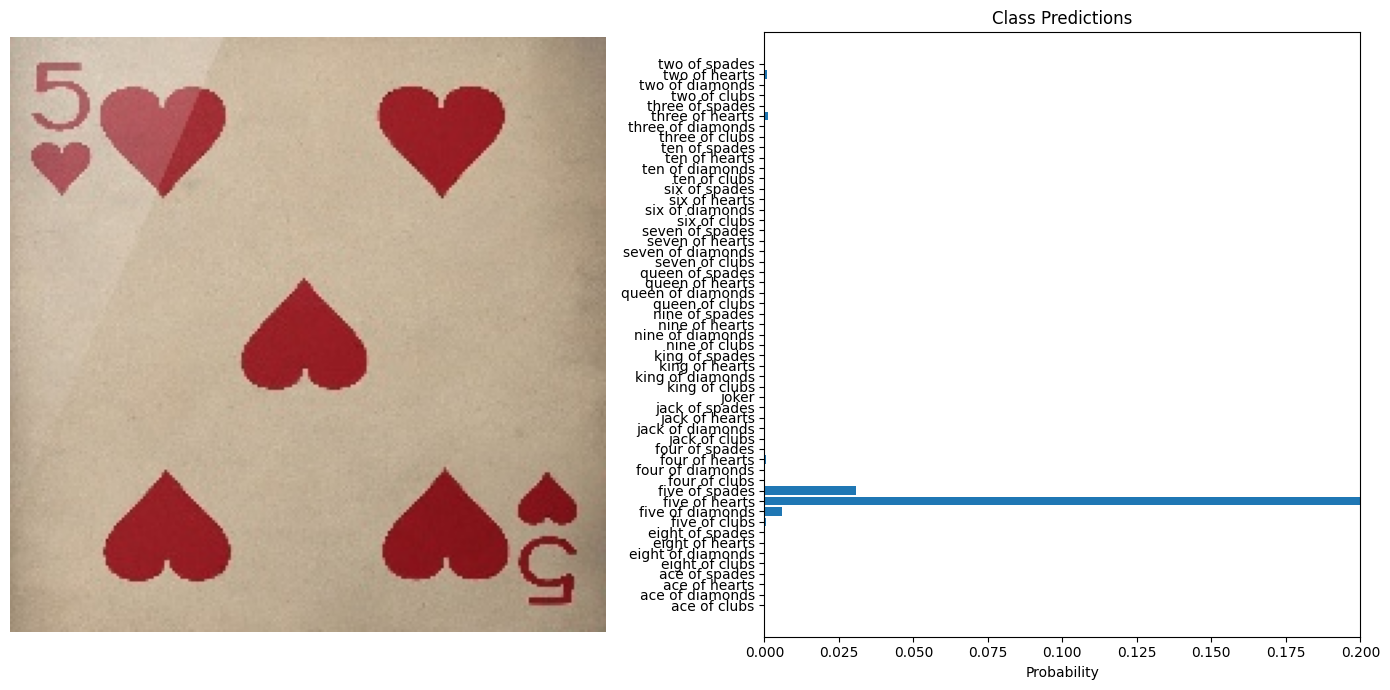

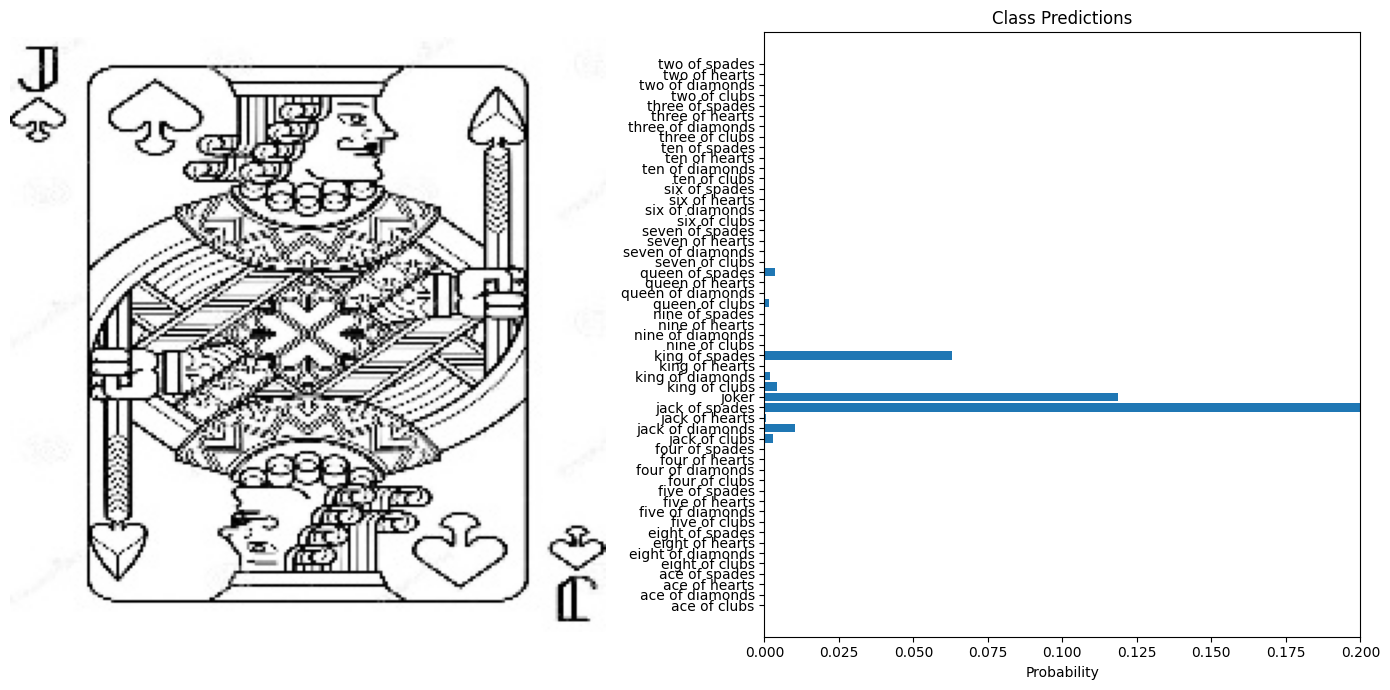

In [37]:
from glob import glob
test_images = glob('./cards_dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
  original_image, image_tensor = preprocess_image(example, transform)
  probabilities = predict(model, image_tensor, device)

  class_names = dataset.classes
  visualize_predictions(original_image, probabilities, class_names)



In [38]:
for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    for i in range(5):  # Show first 5
        print(f"True: {class_names[labels[i]]} | Predicted: {class_names[preds[i]]}")
    break

True: six of clubs | Predicted: six of clubs
True: six of hearts | Predicted: six of hearts
True: queen of hearts | Predicted: queen of hearts
True: king of hearts | Predicted: king of hearts
True: nine of diamonds | Predicted: nine of diamonds


In [39]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8868


In [41]:
torch.save(model.state_dict(), 'card_classifier.pkl')

In [43]:
from google.colab import files
files.download('card_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>